# Using a MLP on lung scans to detect COVID-19

#### Background

We'll be using data from Kaggle. While there are a few different COVID-19 scans data sets, we picked one that is large enough in order to split our data into training/testing/validation sets, but not so large that it takes a long time to train.

This is a publicly available SARS-CoV-2 CT scan dataset, containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1229 CT scans for patients non-infected by SARS-CoV-2, 2481 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil.

**Please Note:** The description of the dataset on Kaggle says that there are 1230 negative CT scans, but it is actually 1229.

*Warning: Each time you want to re-run a model, you need to start fresh, i.e. "Disconnect and delete runtime" otherwise your model will overfit the data.* If you disconnect and delete the runtime, you will need to re-upload the `kaggle.json` file (this file will be obtained in the next step)


## Connect to Kaggle API & Import Libraries

While the data set could be downloaded from Kaggle via your browser and then you could upload all of the data into your notebook, that is not efficient. Thus, we want to connect to Kaggle so that we can download the data diectly. Here is the process.

1. Go to kaggle.com and log-in or create an account.
2. On the upper tab, click on 'Account'.
3. Once you do that, you'll see API and below that, "Create New API Token."
4. After clicking the "Create New API Token," a file named "kaggle.json" will be downloaded.
5. Upload this file into your Colab notebook, just as you would with a data set.

**Please Note:** You can reuse the same .json file, you don't need to create a new API token each time you want to connect to Kaggle.

Before proceeding to the code immediately below, make sure to place kaggle.json in your Colab notebook Files.

This folder deletion command is specific to Google Colab. We're making sure that our runtime doesn't have any of the files or folders that will be created in later steps to make sure that we can run these code cells from top to bottom without error or need for user input when we restart the notebook's runtime.

We're also deleting Google Colab's default `sample_data` folder so that this sample data doesn't accidentally get mixed in with our image data.

In [ ]:
# Remove folders and zip file from Kaggle
# So that we can re-run cells below if necessary
!rm -rf COVID non-COVID sarscov2-ctscan-dataset.zip sample_data dataset

In [ ]:
# We are using Unix commands (each begins with '!') to connect to Kaggle and get the data.
# Set-up the Kaggle directory
!mkdir -p ~/.kaggle

# Copy the json file to this new directory.
!cp kaggle.json ~/.kaggle/

# Allow access to the directory
!chmod 600 ~/.kaggle/kaggle.json

# List the names of the files in the directory
!ls ~/.kaggle

kaggle.json


In [ ]:
# Install Kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

# Download the data set
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

# If you get any errors, its likely due to conflicts in the Python versions and the Unix versions,
# but they should not be an issue. They are more warnings, than errors.

     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 4.2 MB 17.1 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 147 kB 62.3 MB/s 
     |████████████████████████████████| 112 kB 56.2 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-w009hino/lxml_a6c880f27bdd4910a2497922fb84e680/setup.py'"'"'; __file__='"'"'/tmp/pip-install-w009hino/lxml_a6c880f27bdd4910a2497922fb84e680/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-esjo6_z8/install-record.txt --s

In [ ]:
# Unzip the data
!unzip sarscov2-ctscan-dataset.zip

Archive:  sarscov2-ctscan-dataset.zip
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COVID/Covid (1015).png  
  inflating: COVID/Covid (1016).png  
  inflating: COVID/Covid (1017).png  
  inflating: COVID/Covid (1018).png  
  inflating: COVID/Covid (1019).png  
  inflating: COVID/Covid (102).png   
  inflating:

Before we look at the data, let's import our libraries.

In [ ]:
# Import libraries

import pathlib
import PIL

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, ReLU, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Explore the CT Scan Images

The CT scan images in this dataset correspond to one of two diagnoses: `Covid` and `Non-Covid`. We will store the images from each respective class in its own folder.

We will verify that we have the expected number of images and take a look at a few of them.

In [ ]:
# Create folders for the two types of data.

data_dir_covid = pathlib.Path('COVID')
data_dir_non_covid = pathlib.Path('non-COVID')

# Count the number of .png files in each folder.

img_count_covid = len(list(data_dir_covid.glob('*.png'))) 
img_count_non_covid = len(list(data_dir_non_covid.glob('*.png'))) 

print("Image count in Covid set: ", img_count_covid)
print("Image count in Non-Covid set: ", img_count_non_covid)
print("Total Image count: ", (img_count_covid+img_count_non_covid))

Image count in Covid set:  1252
Image count in Non-Covid set:  1229
Total Image count:  2481


In [ ]:
# Grab the images and store them in a list
# So that we can display a few of them.

covid = list(data_dir_covid.glob('*.png'))
non_covid = list(data_dir_non_covid.glob('*.png'))

Change the `image_index` variable below to look at different images.

Image Size:  (356, 336)


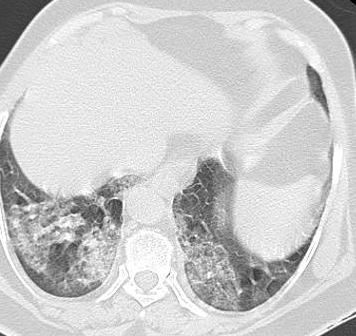

In [ ]:
# CT Scans diagnosed as Covid

image_index = 0

# Print the Image Dimensions
img = PIL.Image.open(covid[image_index])

print("Image Size: ", img.size)

# Look at the Image
img

Image Size:  (364, 260)


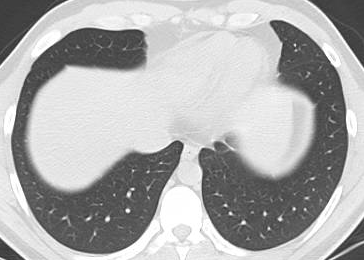

In [ ]:
# CT Scans diagnosed as Non-Covid

image_index = 0

# Print the Image Dimensions
img = PIL.Image.open(non_covid[image_index])

print("Image Size: ", img.size)

# Look at the Image
img

## Create folders for Train, Validation and Test

We will use the `split-folders` Python package to create train, val, and test folders. We will put these within an outer folder called `dataset`. 

- Train (70%) 
- Validation (20%)
- Test (10%)



In [ ]:
# We'll use split-folders to combine the two types of data (Covid/Non-Covid)
# and to further split into train/test/validaiton sets.

# Install split-folders
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Using split-folders to split source folder into the
# train (70%), validation (20%), and test (10%).

# Set the seed to 1337, so that we can replicate the results.

import splitfolders
splitfolders.ratio("../content", output="../content/dataset",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 2484 files [00:01, 1968.55 files/s]


In [ ]:
# Define the path for train, validation and test set

data_dir_train = pathlib.Path('dataset/train')
data_dir_test = pathlib.Path('dataset/test')
data_dir_val = pathlib.Path('dataset/val')

# Check the total image counts (all images are of type .png).
img_count_train = len(list(data_dir_train.glob('*/*.png'))) 
img_count_test = len(list(data_dir_test.glob('*/*.png'))) 
img_count_val = len(list(data_dir_val.glob('*/*.png'))) 

img_count_tot = img_count_train + img_count_test + img_count_val

print("Image count in Train set: ", img_count_train)
print("Image count in Val set: ", img_count_val)
print("Image count in Test set: ", img_count_test)
print("Total image count", img_count_tot)

Image count in Train set:  1736
Image count in Val set:  495
Image count in Test set:  250
Total image count 2481


## Preprocessing and Helper Functions

### Create a "Data Generator"

A Data Generator allows Python to be more efficient in loading the image data as the neural network is training. This is particular important for visual data. This Data Generator will be in charge of resizing the images and preparing each batch to be used during each epoch of training. So We'll need to set these parameters before creating the Data Generator.

Keras has built-in data generator called `ImageDataGenerator`, but it has limited flexibility. So, we'll create our own.

In [ ]:
# Data Generator Parameters
batch_size = 32
img_height = 128
img_width = 128

In [ ]:
# Custom data generator

def data_generator(data_source, img_height, img_width, btc_size):    
    return tf.keras.utils.image_dataset_from_directory(
        data_source,
        validation_split=None, # We already split the data
        subset=None,
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=btc_size,
        crop_to_aspect_ratio=True,
        shuffle=True,
    )

train_ds = data_generator(data_dir_train, img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val, img_height, img_width, batch_size)
test_ds = data_generator(data_dir_test, img_height, img_width, batch_size)

Found 1736 files belonging to 3 classes.
Found 495 files belonging to 3 classes.
Found 250 files belonging to 3 classes.


The "Data Generator" will create a y-variable with corresponding label integers using the folder names found within the each of the `dataset/train`, `dataset/val`, and `dataset/test` folders. Because we want this task to be **binary classification** we need to make sure that there are no other folders or files lurking around in these three folders.

It may say "belonging to 3 classes." or "belonging to 4 classes." above. That's bad. We only want there to be two classes. Let's see what else might be hiding in these folders.

In [ ]:
print("Things in the train folder: ", train_ds.class_names)
print("Things in the val folder: ", val_ds.class_names)
print("Things in the test folder: ", test_ds.class_names)

Things in the train folder:  ['.config', 'COVID', 'non-COVID']
Things in the val folder:  ['.config', 'COVID', 'non-COVID']
Things in the test folder:  ['.config', 'COVID', 'non-COVID']


If you see a `.config` folder or `.ipynb_checkpoints` in any of the there folders, those need to be removed and the dataset variables `train_ds`, `val_ds`, and `test_ds` re-generated. 

In [ ]:
# delete pesky `.config` hidden folder

!rm -rf dataset/train/.config
!rm -rf dataset/test/.config
!rm -rf dataset/val/.config

In [ ]:
train_ds = data_generator(data_dir_train, img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val, img_height, img_width, batch_size)
test_ds = data_generator(data_dir_test, img_height, img_width, batch_size)

Found 1736 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


Much better. Feel free to add additional `!rm -rf` commands above if you need to delete any additional folders.

In [ ]:
print("Things in the train folder: ", train_ds.class_names)
print("Things in the val folder: ", val_ds.class_names)
print("Things in the test folder: ", test_ds.class_names)

Things in the train folder:  ['COVID', 'non-COVID']
Things in the val folder:  ['COVID', 'non-COVID']
Things in the test folder:  ['COVID', 'non-COVID']


This helper function will be useful in graphing the results of our work. 

In [ ]:
# Plot metrics

def plot_metrics(history):       
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model Experiments

### Model 1

The Data Generator is taking care of resizing the images for us, but we still need to mormalize (AKA rescale) the images, and flatten them to prepare them for our Multi-Layer Perceptron model. 

During the guided projects we performed these steps *outside* of our Neural Network, but we can also let Keras take care of these steps for us as preprocessing steps within our `Sequential` model. The `Rescaling()` and `Flatten()` functions here are **not** considered layers of the model because they do not have any trainable parameters associated with them.

With this small dataset, our MLP model may get caught in a local-minimum. If you see the validation accuracy getting stuck at ~50% this may be what's happening. Try training this model a couple of different times to see how often (if ever) if it can avoid getting stuck in a local minimum with our current architecture and hyperparameters.

In [ ]:
# Define the Model
model1 = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                524320    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 524,353
Trainable params: 524,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the Model
history_model1 = model1.fit(train_ds, epochs=10, validation_data=val_ds, workers=1, verbose=1)

Epoch 1/10
55/55 [==============================] - 9s 134ms/step - loss: 0.8601 - accuracy: 0.4833 - val_loss: 0.6932 - val_accuracy: 0.4949
Epoch 2/10
55/55 [==============================] - 9s 147ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 3/10
55/55 [==============================] - 9s 154ms/step - loss: 0.6932 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 4/10
55/55 [==============================] - 9s 147ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 5/10
55/55 [==============================] - 8s 132ms/step - loss: 0.6932 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 6/10
55/55 [==============================] - 8s 132ms/step - loss: 0.6931 - accuracy: 0.5046 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 7/10
55/55 [==============================] - 9s 148ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 

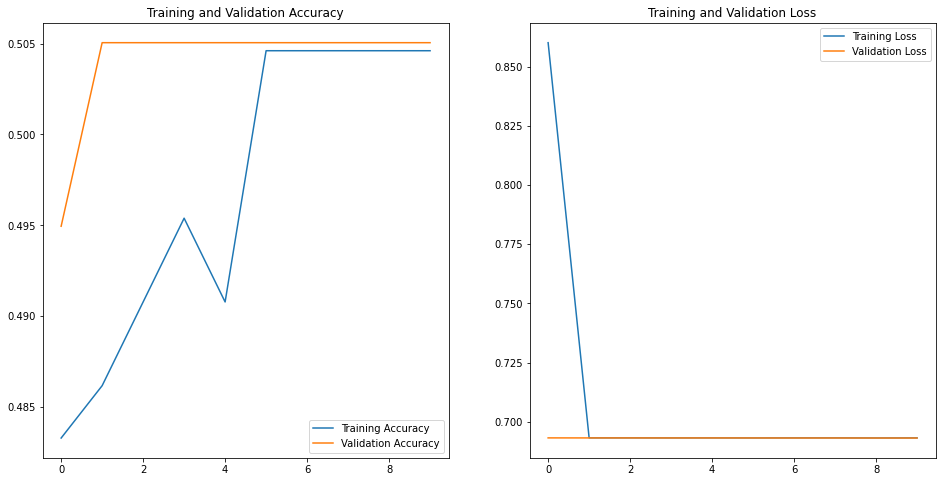

In [ ]:
# Plot Metrics
num_epochs = len(history_model1.history['loss'])
plot_metrics(history_model1)

### Model 2

Any luck getting the model to fit better now that we're normalizing the data? You may have gotten lucky and the model might have fit, but it's still pretty likely to get stuck. Let's try modifying the Adam() optimizer's learning rate to try and help the model not get stuck.

Try out some different learning rates: `(.1, .01, .001, .0001, .00001)`

What is the default learning rate with [Adam()](https://keras.io/api/optimizers/adam/)? 

Why might changing the learning rate help the model to avoid getting stuck in a local minimum? 

In [ ]:
# Define the Model
model2 = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=.0001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                524320    
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 524,353
Trainable params: 524,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the Model
history_model2 = model2.fit(train_ds, epochs=10, validation_data=val_ds, workers=1, verbose=1)

Epoch 1/10
55/55 [==============================] - 12s 193ms/step - loss: 0.6582 - accuracy: 0.5927 - val_loss: 0.6291 - val_accuracy: 0.5960
Epoch 2/10
55/55 [==============================] - 8s 133ms/step - loss: 0.5981 - accuracy: 0.6722 - val_loss: 0.7202 - val_accuracy: 0.5333
Epoch 3/10
55/55 [==============================] - 9s 148ms/step - loss: 0.5869 - accuracy: 0.6861 - val_loss: 0.5451 - val_accuracy: 0.7030
Epoch 4/10
55/55 [==============================] - 8s 133ms/step - loss: 0.5469 - accuracy: 0.7252 - val_loss: 0.5549 - val_accuracy: 0.7172
Epoch 5/10
55/55 [==============================] - 9s 148ms/step - loss: 0.5431 - accuracy: 0.7229 - val_loss: 0.5324 - val_accuracy: 0.7030
Epoch 6/10
55/55 [==============================] - 8s 133ms/step - loss: 0.5422 - accuracy: 0.7241 - val_loss: 0.5903 - val_accuracy: 0.6687
Epoch 7/10
55/55 [==============================] - 8s 132ms/step - loss: 0.5298 - accuracy: 0.7327 - val_loss: 0.5242 - val_accuracy: 0.7232
Epoch

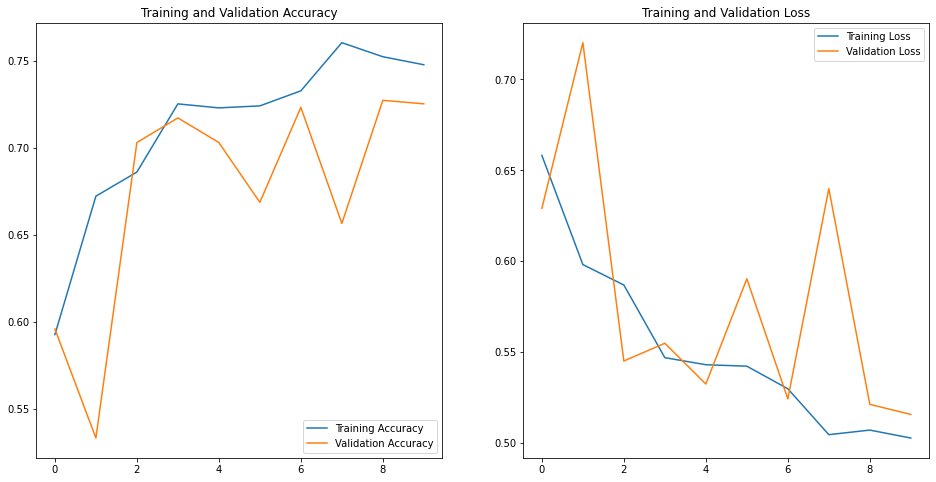

In [ ]:
# Plot Metrics
num_epochs = len(history_model2.history['loss'])
plot_metrics(history_model2)

### Model 3

Ok, now let's beef it up. Let's supe-up the model's architecture. 

In [ ]:
# Define the Model
model3 = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=Adam(learning_rate=.0001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               2097280   
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,107,649
Trainable params: 2,107,649
No

In [ ]:
# Fit the Model
history_model3 = model3.fit(train_ds, epochs=10, validation_data=val_ds, workers=1, verbose=1)

Epoch 1/10
55/55 [==============================] - 10s 148ms/step - loss: 0.6335 - accuracy: 0.6256 - val_loss: 0.5829 - val_accuracy: 0.6848
Epoch 2/10
55/55 [==============================] - 9s 141ms/step - loss: 0.5570 - accuracy: 0.7085 - val_loss: 0.6043 - val_accuracy: 0.6828
Epoch 3/10
55/55 [==============================] - 9s 140ms/step - loss: 0.5714 - accuracy: 0.7028 - val_loss: 0.5311 - val_accuracy: 0.7313
Epoch 4/10
55/55 [==============================] - 9s 156ms/step - loss: 0.5351 - accuracy: 0.7287 - val_loss: 0.5494 - val_accuracy: 0.6970
Epoch 5/10
55/55 [==============================] - 9s 141ms/step - loss: 0.5039 - accuracy: 0.7644 - val_loss: 0.6018 - val_accuracy: 0.6828
Epoch 6/10
55/55 [==============================] - 9s 141ms/step - loss: 0.5499 - accuracy: 0.7085 - val_loss: 0.5572 - val_accuracy: 0.6848
Epoch 7/10
55/55 [==============================] - 9s 141ms/step - loss: 0.4965 - accuracy: 0.7604 - val_loss: 0.5286 - val_accuracy: 0.7172
Epoch

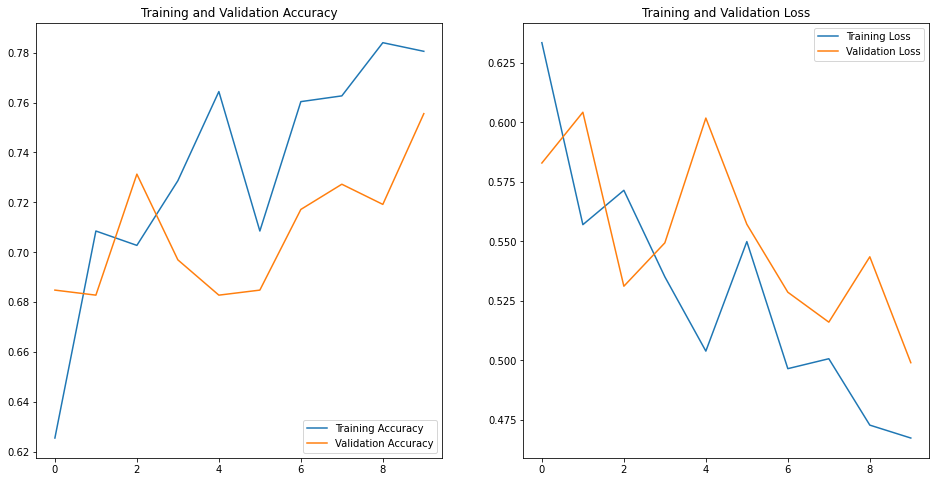

In [ ]:
# Plot Metrics
num_epochs = len(history_model3.history['loss'])
plot_metrics(history_model3)

### Model 4

Let's use bigger images, and more epochs! This will take longer to train, but should get better overall results.

In [ ]:
# Data Generator Parameters
batch_size = 32
img_height = 256
img_width = 256

train_ds = data_generator(data_dir_train, img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val, img_height, img_width, batch_size)
test_ds = data_generator(data_dir_test, img_height, img_width, batch_size)

Found 1736 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


In [ ]:
# Define the Model
model4 = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model4.compile(optimizer=Adam(learning_rate=.0001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 flatten_4 (Flatten)         (None, 65536)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               16777472  
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                

In [ ]:
# Fit the Model
history_model4 = model4.fit(train_ds, epochs=20, validation_data=val_ds, workers=1, verbose=1)

Epoch 1/20
55/55 [==============================] - 15s 237ms/step - loss: 0.7132 - accuracy: 0.5864 - val_loss: 0.6601 - val_accuracy: 0.5636
Epoch 2/20
55/55 [==============================] - 14s 232ms/step - loss: 0.6068 - accuracy: 0.6717 - val_loss: 0.5544 - val_accuracy: 0.7071
Epoch 3/20
55/55 [==============================] - 14s 235ms/step - loss: 0.5585 - accuracy: 0.7051 - val_loss: 0.5352 - val_accuracy: 0.7313
Epoch 4/20
55/55 [==============================] - 14s 235ms/step - loss: 0.5296 - accuracy: 0.7275 - val_loss: 0.5247 - val_accuracy: 0.7313
Epoch 5/20
55/55 [==============================] - 14s 234ms/step - loss: 0.5438 - accuracy: 0.7252 - val_loss: 0.6340 - val_accuracy: 0.6707
Epoch 6/20
55/55 [==============================] - 14s 233ms/step - loss: 0.5243 - accuracy: 0.7379 - val_loss: 0.5424 - val_accuracy: 0.7111
Epoch 7/20
55/55 [==============================] - 14s 232ms/step - loss: 0.4955 - accuracy: 0.7650 - val_loss: 0.5185 - val_accuracy: 0.7414

In [ ]:
# Accuracy
min_loss_index = history_model4.history['val_loss'].index(min(history_model4.history['val_loss']))
print("Training Accuracy: ", history_model4.history['accuracy'][min_loss_index])
print("Validation Accuracy: ", history_model4.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.8116359710693359
Validation Accuracy:  0.7515151500701904


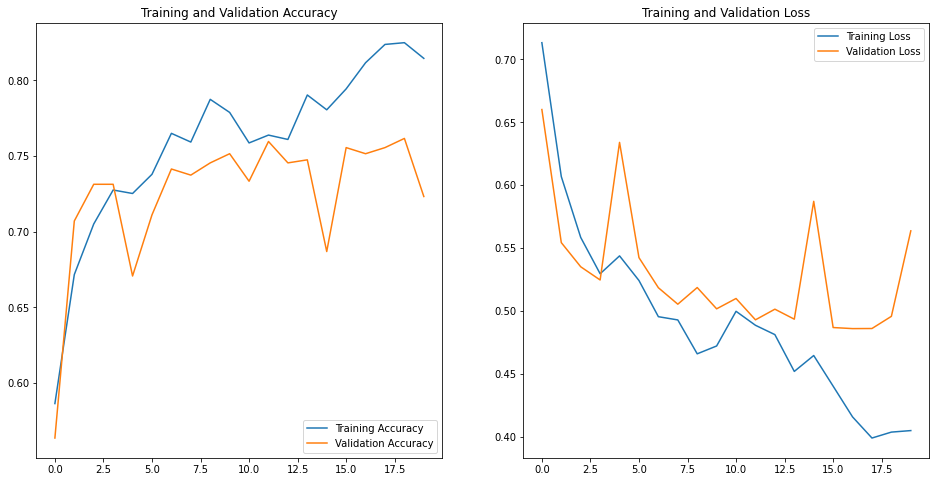

In [ ]:
# Plot Metrics
num_epochs = len(history_model4.history['loss'])
plot_metrics(history_model4)

In [ ]:
# Since this seems to be our best model. Let's see how it does on our test dataset.
# The ultimate goal is to train a model that generalizes well to unseen data.
test_loss, test_acc = model4.evaluate(test_ds, batch_size=batch_size, verbose=2)

8/8 - 1s - loss: 0.5415 - accuracy: 0.7760 - 1s/epoch - 152ms/step
